In [1]:
from model_gradcam_code import *
from utils import *

import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

e:\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
e:\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you'

In [2]:
df = pd.read_csv('images/data.csv', sep='\t')
df

,filename,tortuous,tortuous_points
0,images/tortuous/0.png,1,"[(573.6222026782206, 132.54680276738213), (456..."
1,images/tortuous/1.png,1,"[(211.97427214185615, 464.3646937645268), (254..."
2,images/tortuous/2.png,1,"[(193.2826815856427, 319.5667894455212), (199...."
3,images/tortuous/3.png,1,"[(219.68963451599217, 339.35612070918205), (57..."
4,images/tortuous/4.png,1,"[(301.01794476009184, 161.3606998669253), (66...."
...,...,...,...
1995,images/non_tortuous/995.png,0,[]
1996,images/non_tortuous/996.png,0,[]
1997,images/non_tortuous/997.png,0,[]
1998,images/non_tortuous/998.png,0,[]


6570 35277


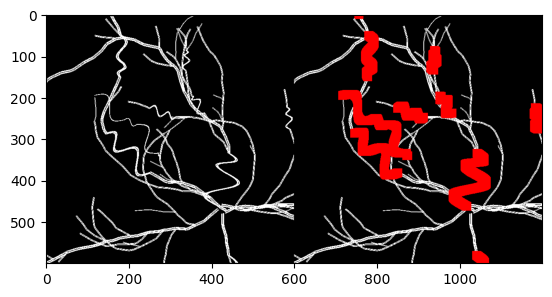

In [3]:
idx = random.randint(0, len(df)//2)

img_name = df.iloc[idx]['filename']
tortuous_points = df.iloc[idx]['tortuous_points']
tortuous_points = parse_points_list(tortuous_points)

final_tortuous_points = set()

img = Image.open(img_name)
img = np.array(img)
initial_img = img.copy()

fig, ax = plt.subplots()
ax.imshow(img)

dx = dy = 10
for (x, y) in tortuous_points:
    for i in range(x-dx, x+dx+1):
        for j in range(y-dy, y+dy+1):
            if 0 <= i < img.shape[0] and 0 <= j < img.shape[1]:
                final_tortuous_points.add((i, j))
                img[i][j] = [255, 0, 0]

print(len(tortuous_points), len(final_tortuous_points))


plt.imshow(np.hstack([initial_img, img]))

In [4]:
def get_all_tortous_points(tortuous_points):
    tortuous_points = parse_points_list(tortuous_points)

    final_tortuous_points = set()
    dx = dy = 10
    for (x, y) in tortuous_points:
        for i in range(x-dx, x+dx+1):
            for j in range(y-dy, y+dy+1):
                if 0 <= i < ORIG_IMG_SIZE and 0 <= j < ORIG_IMG_SIZE:
                    final_tortuous_points.add((i, j))

    print(len(tortuous_points), len(final_tortuous_points))
    return final_tortuous_points

In [5]:
def get_random_sample(n = 5, cls="1"):
    samples = test_df[test_df.tortuous == cls].sample(n)
    images = np.array([open_image(filename) for filename in samples.filename])
    print(images.shape)
    tortuous_points_batch = [get_all_tortous_points(tortuous_points) for tortuous_points in samples.tortuous_points]
    pred_labels = tf.argmax(global_model(tf.convert_to_tensor(images)), axis=1).numpy().tolist()
    return images, samples.tortuous, pred_labels, tortuous_points_batch

In [29]:
def split_heatmap_percentile(heatmap, min_threshold_percentile, max_threshold_percentile):
    min_percentile_value = np.percentile(heatmap, min_threshold_percentile)
    max_percentile_value = np.percentile(heatmap, max_threshold_percentile)

    return (np.where(heatmap <= min_percentile_value, 1, 0),
            np.where(heatmap >= max_percentile_value, 1, 0))

def split_heatmap_threshold(heatmap, min_threshold, max_threshold):
    return (np.where(heatmap <= min_threshold, 1, 0),
            np.where(heatmap >= max_threshold, 1, 0))

def get_cropped_images(images, min_thres, max_thres):
    heatmaps = [attention_map(model=global_model, image=img) for img in images]
    regions_batch = [split_heatmap_percentile(heatmap, min_thres, max_thres) for heatmap in heatmaps]

    regions_batch = np.squeeze(np.array(regions_batch))

    cropped_regions_batch = [
        [img*np.stack([region] * 3, axis=-1) for region in regions] 
        for img, regions in zip(images, regions_batch)
    ]

    return cropped_regions_batch

In [40]:
MIN_THRESHOLD_PERCENTILE = 10
MAX_THRESHOLD_PERCENTILE = 95
N = 5
MIN_LENGTH = 10
ORIG_IMG_SIZE = 600

In [41]:
images, labels, pred_labels, tortuous_points_batch = get_random_sample(N, cls="1")

(5, 384, 384, 3)
9425 49685
8300 41744
7200 38278
1775 10568
2522 16323


In [42]:
cropped_regions_batch = get_cropped_images(images, MIN_THRESHOLD_PERCENTILE, MAX_THRESHOLD_PERCENTILE)

1/1 [==============================] - 0s 161ms/step


In [43]:
# In the cropped images, check how many tortuous points are present

def get_tortuous_points_in_region(images, cropped_region_batch, tortuous_points_batch):
    n = len(images)
    fig, axs = plt.subplots(n, 4, figsize=(12, n * 3))

    percentage_scores = []

    # plt.suptitle(r"Total tortuous points, Points in region, Tortuous points in region, % of tortuous points captured, % of captured that are tortuous")
    for i, orig_img, cropped_region, tortuous_points in zip(range(n), images, cropped_region_batch, tortuous_points_batch):
        high_att_gradcam = cropped_region[1][:, :, 0]
        print(high_att_gradcam.shape)
        print(np.array(cropped_region).shape)
        print(cropped_region[1].shape)

        # Create an image with the tortuous points
        tortuous_img = np.zeros((ORIG_IMG_SIZE, ORIG_IMG_SIZE))
        for (x, y) in tortuous_points:
            tortuous_img[x, y] = 1
        tortuous_img = Image.fromarray(tortuous_img.astype(np.uint8))
        tortuous_img = tortuous_img.resize((IMG_SIZE, IMG_SIZE))
        tortuous_img = np.array(tortuous_img).astype(np.float32)

        tortuous_img *= orig_img[:, :, 0]

        num_tortuous_points = tortuous_img.sum()

        cnt = np.sum(high_att_gradcam*tortuous_img)

        print(f"Image: {i+1}")
        print(f"Total points: {num_tortuous_points}, Total points captured: {np.sum(high_att_gradcam)}, Tortuous points captured: {cnt}")
        print(f"{cnt/num_tortuous_points*100:.2f}% of tortuous points are captured by the gradcam")
        print(f"{cnt/np.sum(high_att_gradcam)*100:.2f}% of the captured region is tortuous")

        percentage_scores.append((cnt/np.sum(high_att_gradcam)*100, cnt/num_tortuous_points*100))

        axs[i, 0].imshow(orig_img[:, :, 0], cmap='gray')
        axs[i, 0].set_title("Image")


        axs[i, 1].imshow(tortuous_img, cmap='gray')
        axs[i, 1].set_title("Tortuous regions (Ground truth)")
        
        axs[i, 2].imshow(high_att_gradcam, cmap='gray')
        axs[i, 2].set_title("High attention region")

        axs[i, 3].imshow(high_att_gradcam*tortuous_img, cmap='gray')
        axs[i, 3].set_title(
            f"Overlap P: ({cnt/np.sum(high_att_gradcam)*100:.2f}%) | R: ({cnt/num_tortuous_points*100:.2f}%)"
        )
            # ({cnt/num_tortuous_points*100:.2f}%) of tortuous points are captured by the gradcam

    # Print mean of percentage scores
    consolidated_scores = np.mean(percentage_scores, axis=0)
    print(f"Mean of percentage scores: {consolidated_scores}")


    plt.tight_layout()
    plt.show()
    return consolidated_scores

(384, 384)
(2, 384, 384, 3)
(384, 384, 3)
Image: 1
Total points: 4596.0, Total points captured: 1578.0, Tortuous points captured: 1012.0
22.02% of tortuous points are captured by the gradcam
64.13% of the captured region is tortuous
(384, 384)
(2, 384, 384, 3)
(384, 384, 3)
Image: 2
Total points: 4280.0, Total points captured: 1785.0, Tortuous points captured: 819.0
19.14% of tortuous points are captured by the gradcam
45.88% of the captured region is tortuous
(384, 384)
(2, 384, 384, 3)
(384, 384, 3)
Image: 3
Total points: 3754.0, Total points captured: 1490.0, Tortuous points captured: 831.0
22.14% of tortuous points are captured by the gradcam
55.77% of the captured region is tortuous
(384, 384)
(2, 384, 384, 3)
(384, 384, 3)
Image: 4
Total points: 1072.0, Total points captured: 1846.0, Tortuous points captured: 422.0
39.37% of tortuous points are captured by the gradcam
22.86% of the captured region is tortuous
(384, 384)
(2, 384, 384, 3)
(384, 384, 3)
Image: 5
Total points: 1332.0

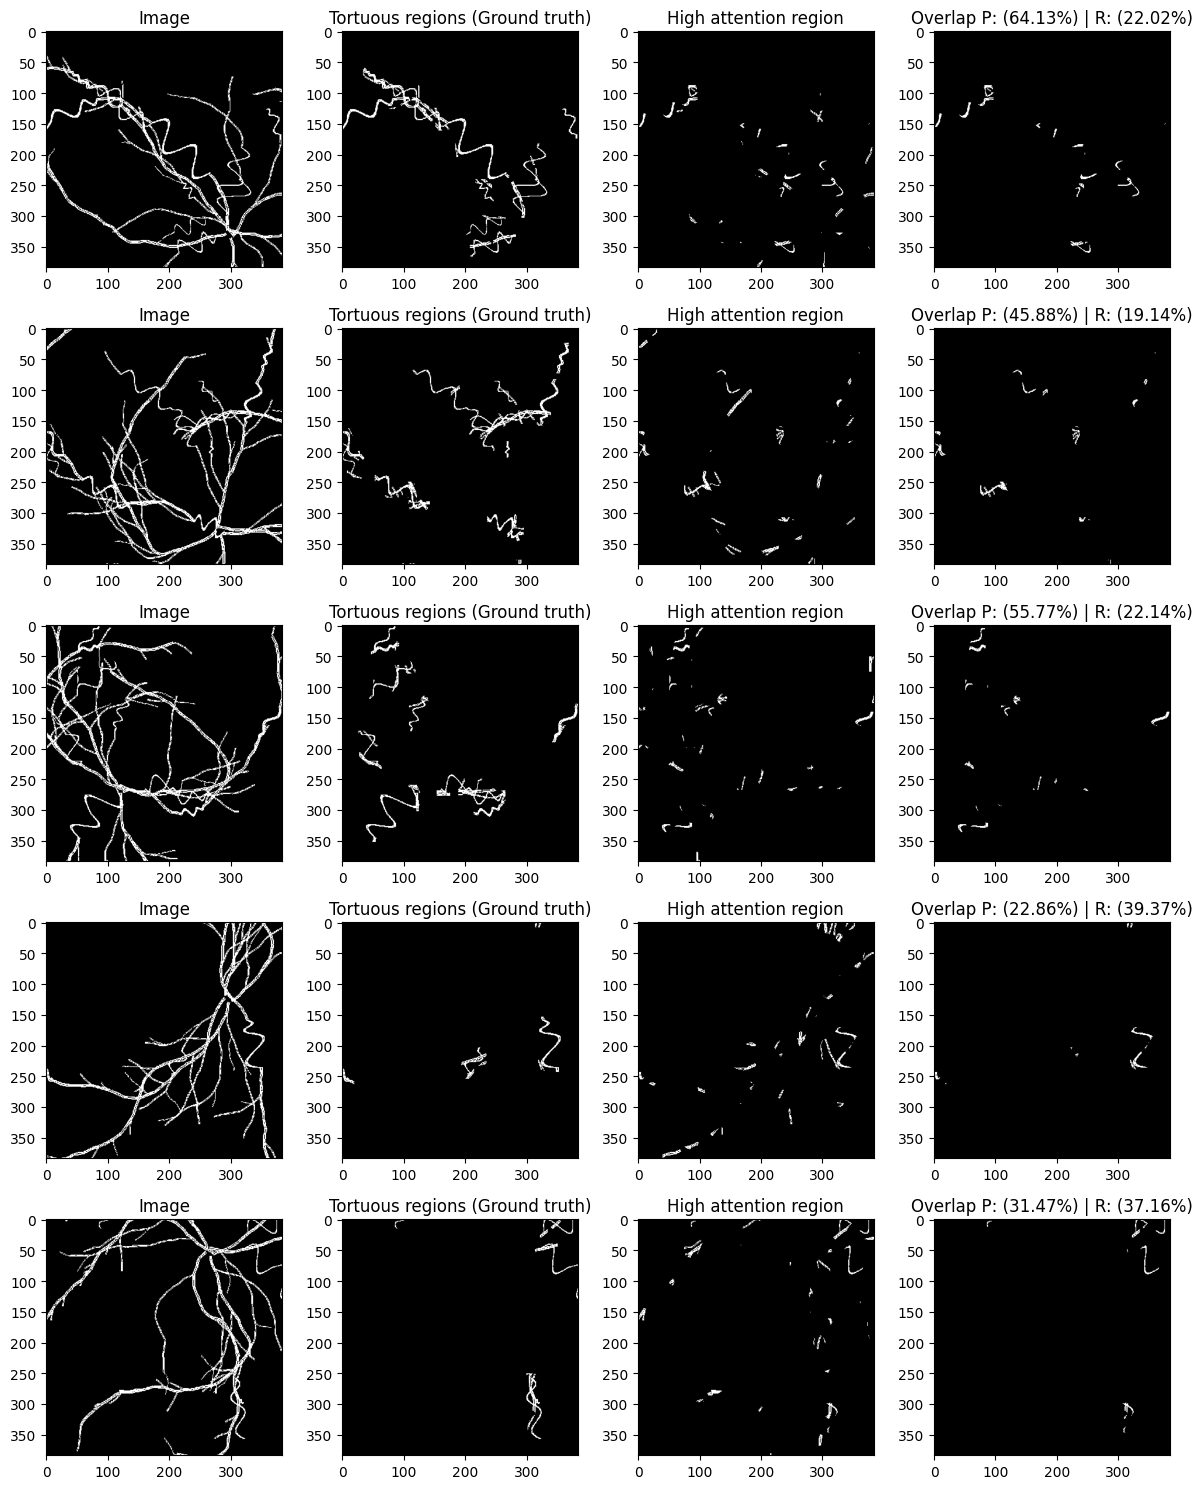

array([44.02294945, 27.96377655])

In [44]:
get_tortuous_points_in_region(images, cropped_regions_batch, tortuous_points_batch)

1/1 [==============================] - 0s 154ms/step
(384, 384)
(2, 384, 384, 3)
(384, 384, 3)
Image: 1
Total points: 1471.0, Total points captured: 8197.0, Tortuous points captured: 1471.0
100.00% of tortuous points are captured by the gradcam
17.95% of the captured region is tortuous
(384, 384)
(2, 384, 384, 3)
(384, 384, 3)
Image: 2
Total points: 3691.0, Total points captured: 13210.0, Tortuous points captured: 3691.0
100.00% of tortuous points are captured by the gradcam
27.94% of the captured region is tortuous
(384, 384)
(2, 384, 384, 3)
(384, 384, 3)
Image: 3
Total points: 2890.0, Total points captured: 13644.0, Tortuous points captured: 2837.0
98.17% of tortuous points are captured by the gradcam
20.79% of the captured region is tortuous
(384, 384)
(2, 384, 384, 3)
(384, 384, 3)
Image: 4
Total points: 1096.0, Total points captured: 9183.0, Tortuous points captured: 1096.0
100.00% of tortuous points are captured by the gradcam
11.94% of the captured region is tortuous
(384, 384)

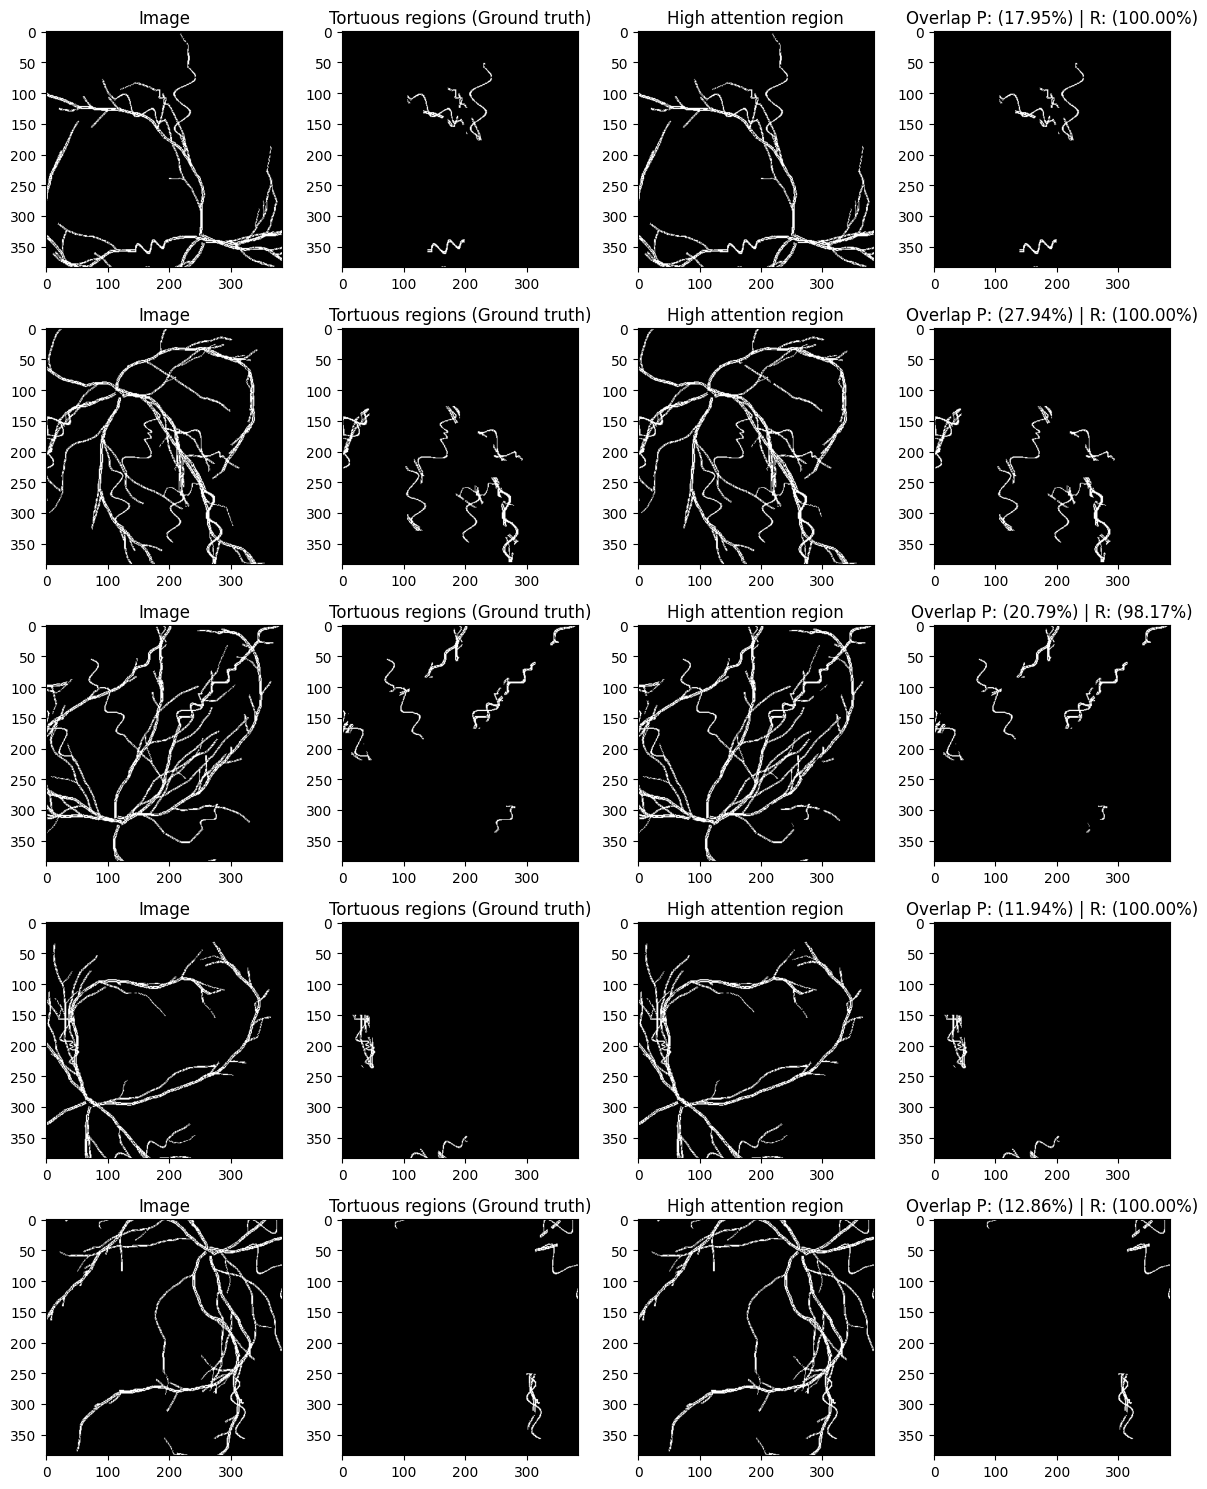

1/1 [==============================] - 0s 163ms/step
(384, 384)
(2, 384, 384, 3)
(384, 384, 3)
Image: 1
Total points: 1471.0, Total points captured: 7584.0, Tortuous points captured: 1385.0
94.15% of tortuous points are captured by the gradcam
18.26% of the captured region is tortuous
(384, 384)
(2, 384, 384, 3)
(384, 384, 3)
Image: 2
Total points: 3691.0, Total points captured: 8398.0, Tortuous points captured: 2812.0
76.19% of tortuous points are captured by the gradcam
33.48% of the captured region is tortuous
(384, 384)
(2, 384, 384, 3)
(384, 384, 3)
Image: 3
Total points: 2890.0, Total points captured: 8487.0, Tortuous points captured: 2206.0
76.33% of tortuous points are captured by the gradcam
25.99% of the captured region is tortuous
(384, 384)
(2, 384, 384, 3)
(384, 384, 3)
Image: 4
Total points: 1096.0, Total points captured: 7794.0, Tortuous points captured: 1069.0
97.54% of tortuous points are captured by the gradcam
13.72% of the captured region is tortuous
(384, 384)
(2, 

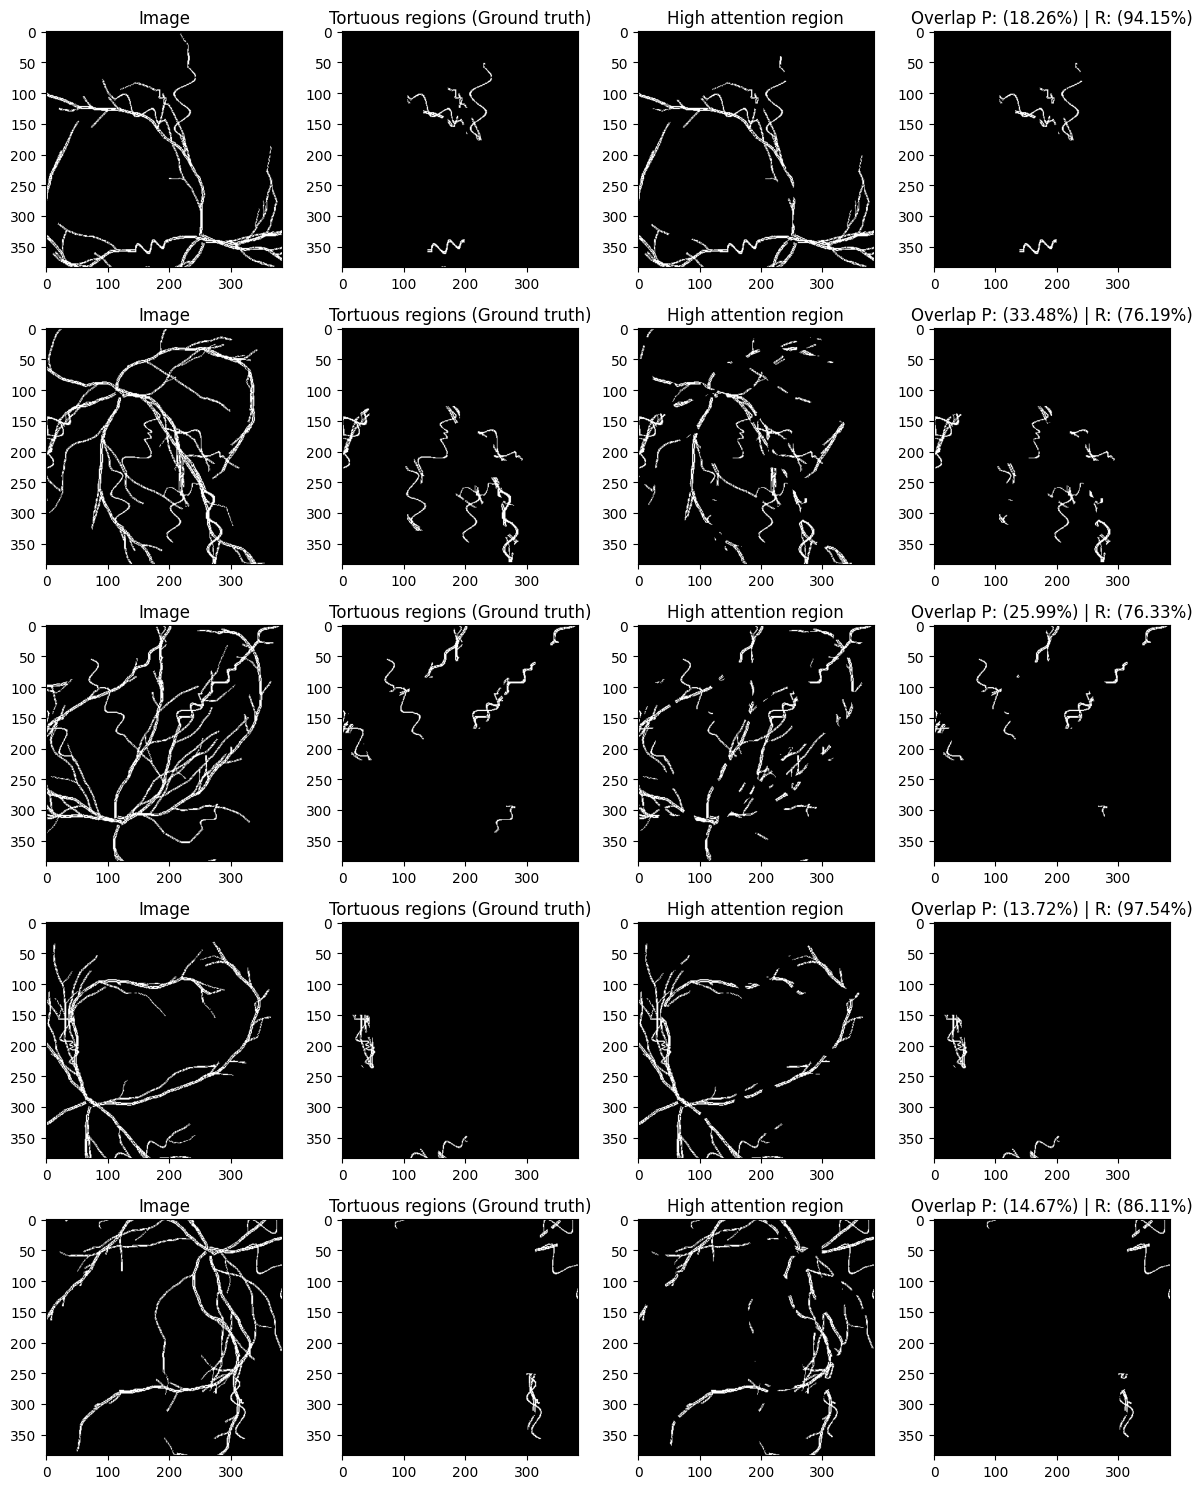

1/1 [==============================] - 0s 166ms/step
(384, 384)
(2, 384, 384, 3)
(384, 384, 3)
Image: 1
Total points: 1471.0, Total points captured: 6661.0, Tortuous points captured: 1210.0
82.26% of tortuous points are captured by the gradcam
18.17% of the captured region is tortuous
(384, 384)
(2, 384, 384, 3)
(384, 384, 3)
Image: 2
Total points: 3691.0, Total points captured: 6938.0, Tortuous points captured: 2454.0
66.49% of tortuous points are captured by the gradcam
35.37% of the captured region is tortuous
(384, 384)
(2, 384, 384, 3)
(384, 384, 3)
Image: 3
Total points: 2890.0, Total points captured: 6772.0, Tortuous points captured: 1963.0
67.92% of tortuous points are captured by the gradcam
28.99% of the captured region is tortuous
(384, 384)
(2, 384, 384, 3)
(384, 384, 3)
Image: 4
Total points: 1096.0, Total points captured: 6463.0, Tortuous points captured: 1016.0
92.70% of tortuous points are captured by the gradcam
15.72% of the captured region is tortuous
(384, 384)
(2, 

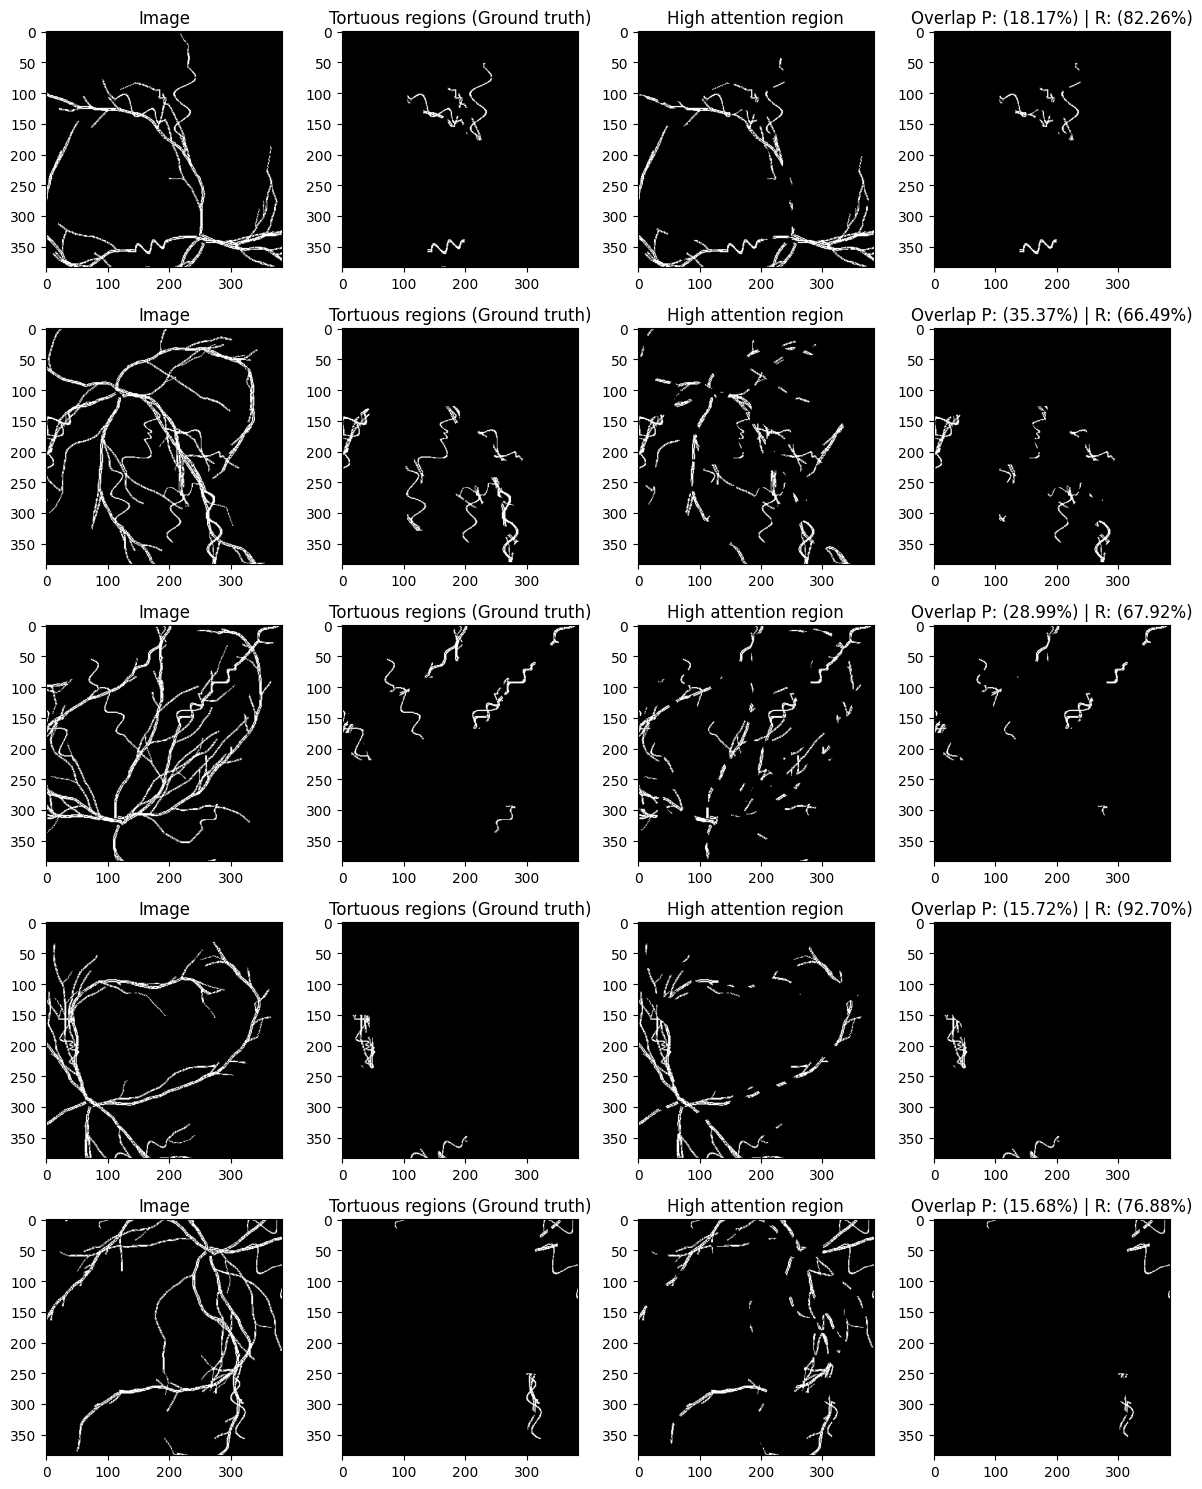

1/1 [==============================] - 0s 166ms/step
(384, 384)
(2, 384, 384, 3)
(384, 384, 3)
Image: 1
Total points: 1471.0, Total points captured: 3709.0, Tortuous points captured: 647.0
43.98% of tortuous points are captured by the gradcam
17.44% of the captured region is tortuous
(384, 384)
(2, 384, 384, 3)
(384, 384, 3)
Image: 2
Total points: 3691.0, Total points captured: 4029.0, Tortuous points captured: 1723.0
46.68% of tortuous points are captured by the gradcam
42.76% of the captured region is tortuous
(384, 384)
(2, 384, 384, 3)
(384, 384, 3)
Image: 3
Total points: 2890.0, Total points captured: 3482.0, Tortuous points captured: 1325.0
45.85% of tortuous points are captured by the gradcam
38.05% of the captured region is tortuous
(384, 384)
(2, 384, 384, 3)
(384, 384, 3)
Image: 4
Total points: 1096.0, Total points captured: 3330.0, Tortuous points captured: 806.0
73.54% of tortuous points are captured by the gradcam
24.20% of the captured region is tortuous
(384, 384)
(2, 38

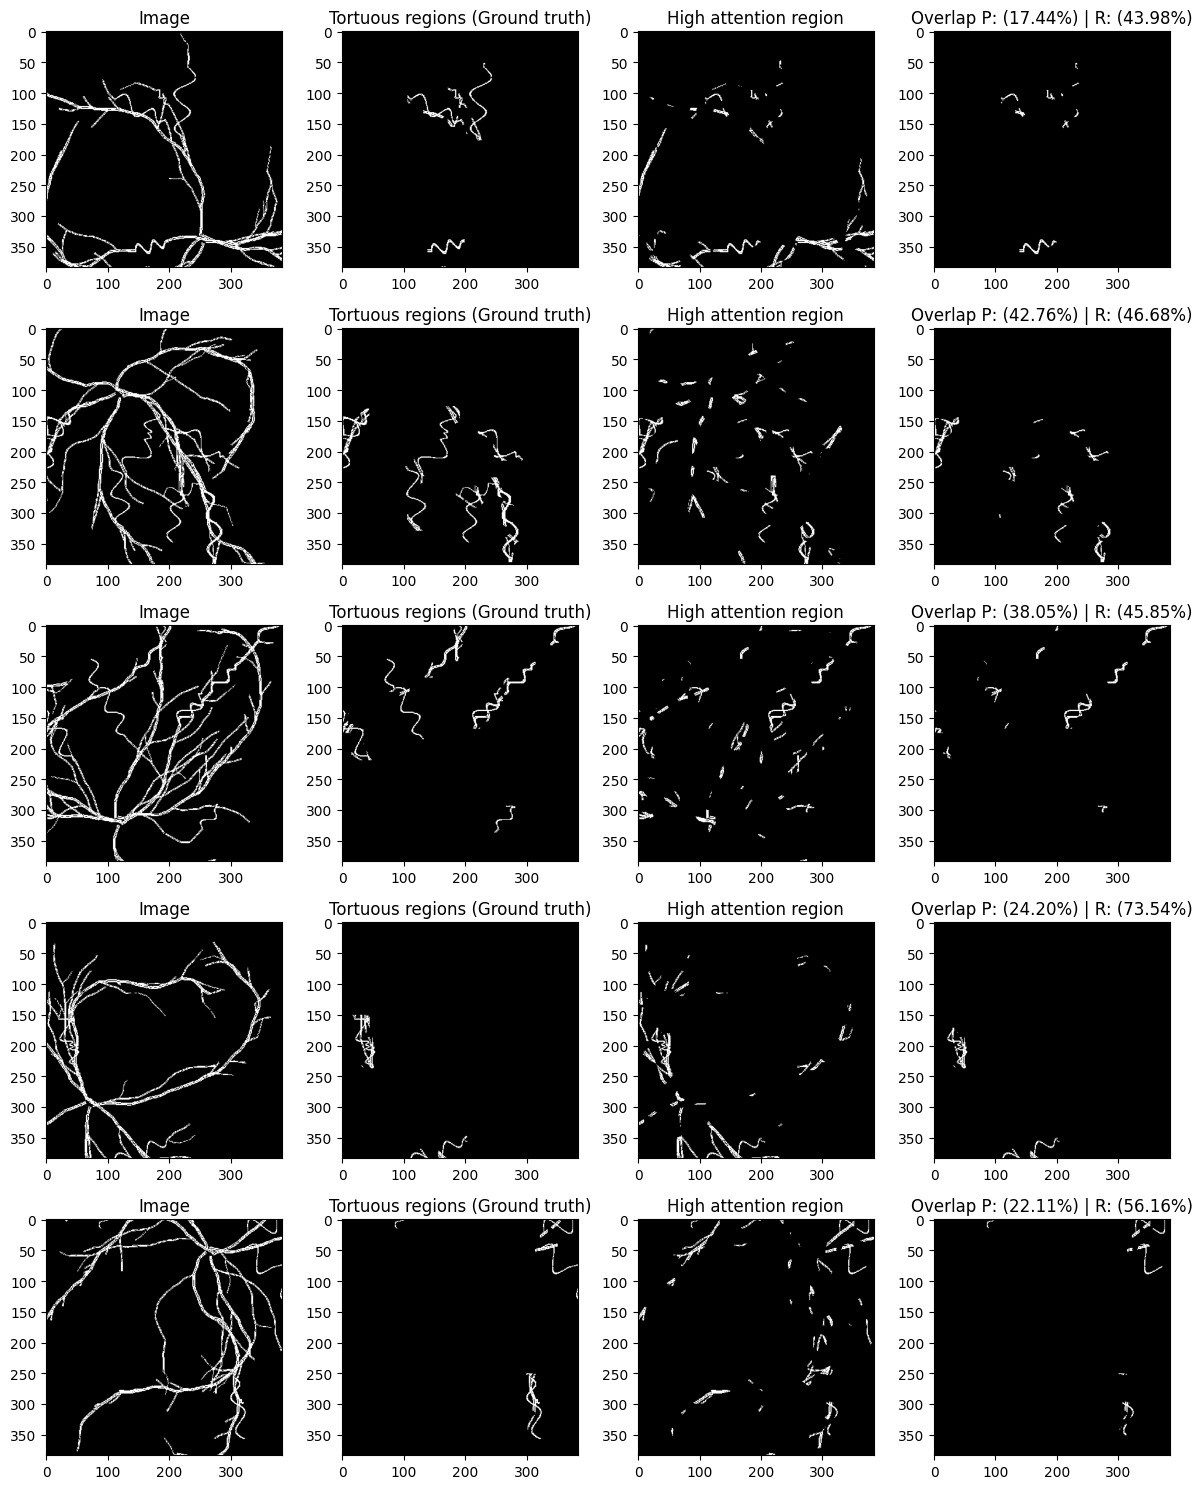

1/1 [==============================] - 0s 163ms/step
(384, 384)
(2, 384, 384, 3)
(384, 384, 3)
Image: 1
Total points: 1471.0, Total points captured: 2048.0, Tortuous points captured: 394.0
26.78% of tortuous points are captured by the gradcam
19.24% of the captured region is tortuous
(384, 384)
(2, 384, 384, 3)
(384, 384, 3)
Image: 2
Total points: 3691.0, Total points captured: 2150.0, Tortuous points captured: 1065.0
28.85% of tortuous points are captured by the gradcam
49.53% of the captured region is tortuous
(384, 384)
(2, 384, 384, 3)
(384, 384, 3)
Image: 3
Total points: 2890.0, Total points captured: 1853.0, Tortuous points captured: 914.0
31.63% of tortuous points are captured by the gradcam
49.33% of the captured region is tortuous
(384, 384)
(2, 384, 384, 3)
(384, 384, 3)
Image: 4
Total points: 1096.0, Total points captured: 1415.0, Tortuous points captured: 345.0
31.48% of tortuous points are captured by the gradcam
24.38% of the captured region is tortuous
(384, 384)
(2, 384

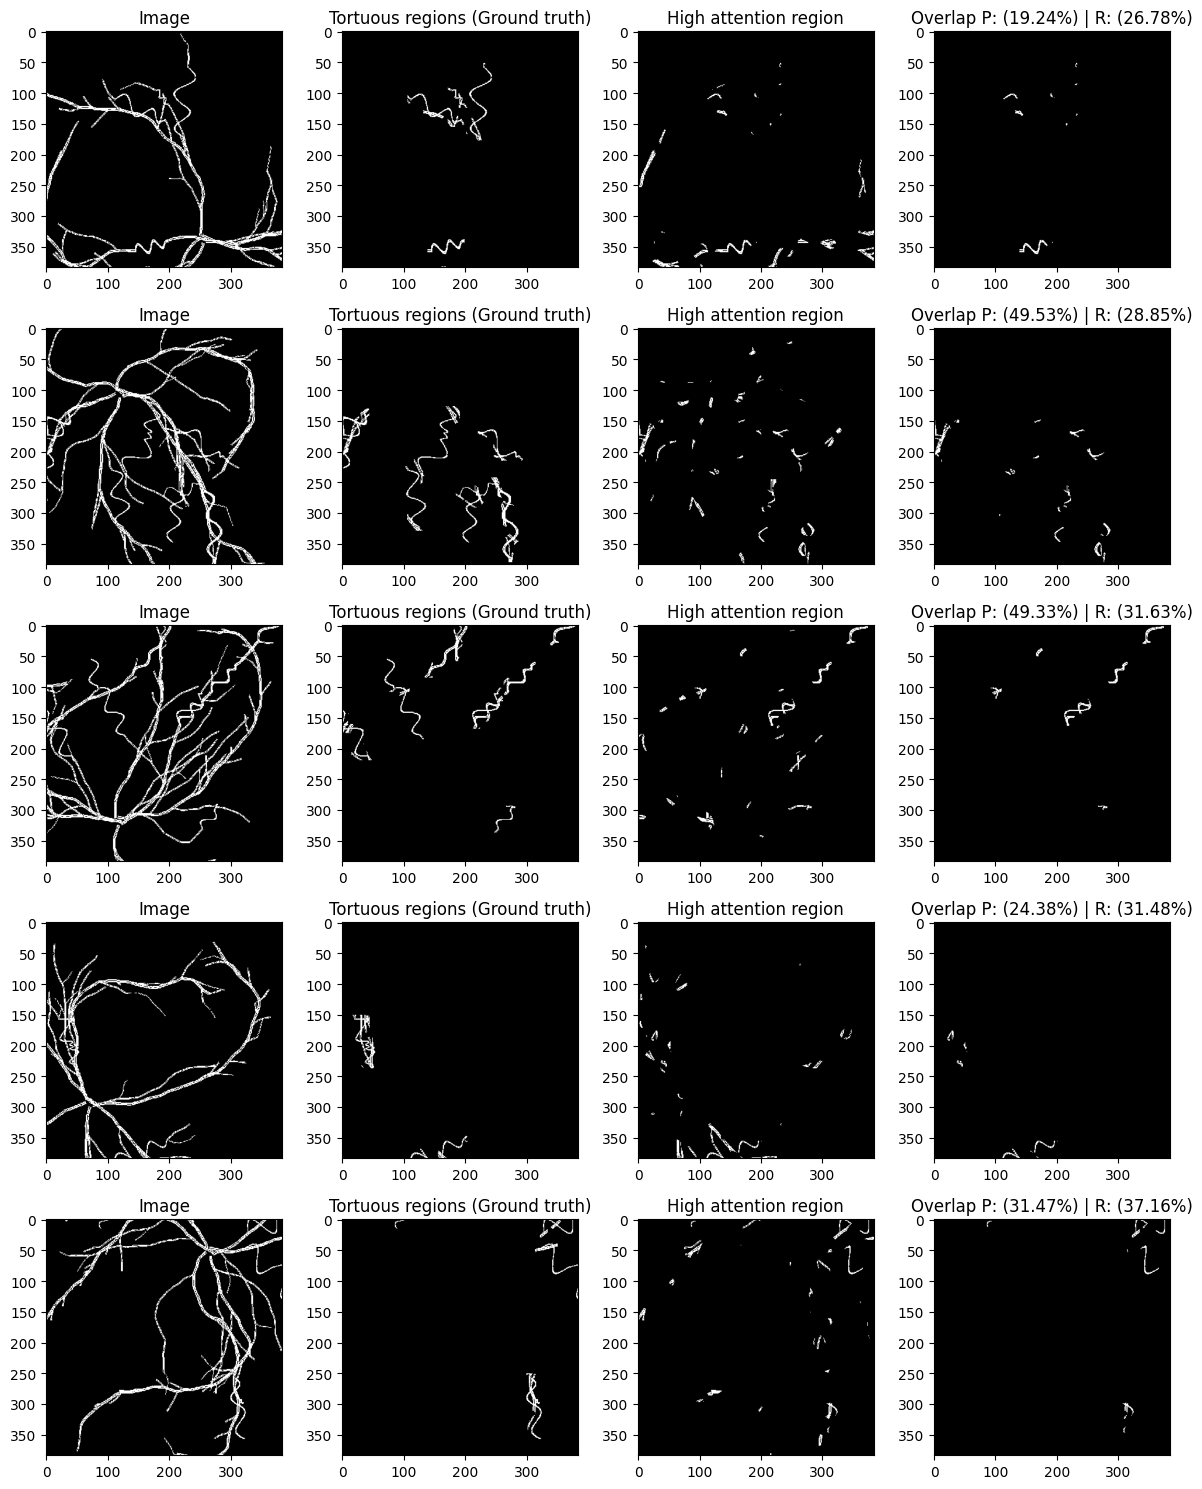

[array([18.29510615, 99.63321799]), array([21.22556308, 86.063748  ]), array([22.78539908, 77.24889949]), array([28.91532185, 53.24177076]), array([34.78974802, 31.18100628])]


In [36]:
threshold_percentiles = [50, 75, 80, 90, 95]
results = []
for percentile in threshold_percentiles:
    cropped_regions_batch = get_cropped_images(images, 10, percentile)
    result = get_tortuous_points_in_region(images, cropped_regions_batch, tortuous_points_batch)
    results.append(result)
print(results)

In [38]:
for result in results:
    print(result)

[18.29510615 99.63321799]
[21.22556308 86.063748  ]
[22.78539908 77.24889949]
[28.91532185 53.24177076]
[34.78974802 31.18100628]


In [39]:
# calculate f1 score for the results
def calculate_f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall)

for result in results:
    print(calculate_f1_score(*result))

30.913698004196842
34.05281465051721
35.19087010214611
37.477054955582126
32.886674193933295
